In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
# Install required libraries
%pip install -q transformers datasets

Note: you may need to restart the kernel to use updated packages.


In [98]:
# Import necessary libraries
import numpy as np
import os
from datasets import load_dataset
import matplotlib.pyplot as plt
from PIL import Image
import torch
from transformers import ViTForImageClassification, ViTImageProcessor, Trainer, TrainingArguments
from torchvision.transforms import (Compose, Normalize, RandomHorizontalFlip, Resize, ToTensor)
import cv2
import torch
from PIL import Image
from transformers import ViTForImageClassification, ViTImageProcessor
from torch.utils.data import DataLoader
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score
import numpy as np

In [104]:
# Load dataset
data_dir = '../dataset_complete'  # Update the path if necessary
dataset = load_dataset('imagefolder', data_dir=data_dir)
dataset = dataset['train'].train_test_split(test_size=0.2)
train_data = dataset['train']
test_data = dataset['test']

Resolving data files:   0%|          | 0/25569 [00:00<?, ?it/s]

In [105]:
# Extract labels as folder names (class names)
labels = sorted(os.listdir(data_dir))
id2label = {id: label for id, label in enumerate(labels)}
label2id = {label: id for id, label in id2label.items()}

# Print the mappings
print("ID to Label Mapping:", id2label)
print("Label to ID Mapping:", label2id)

ID to Label Mapping: {0: 'Ain', 1: 'Alif', 2: 'Barri_Yay', 3: 'Bay', 4: 'Cay', 5: 'Chay', 6: 'Chotti_Yay', 7: 'Daal', 8: 'Dhaal', 9: 'Dwaat', 10: 'Fay', 11: 'Gaaf', 12: 'Ghain', 13: 'Gzay', 14: 'Haaaaa', 15: 'Hamza_Alif', 16: 'Hay', 17: 'Jeem', 18: 'Kaaf', 19: 'Khay', 20: 'Laam', 21: 'Meem', 22: 'Noon', 23: 'Pay', 24: 'Qaaf', 25: 'Ray', 26: 'Rray', 27: 'Seen', 28: 'Sheen', 29: 'Swaat', 30: 'Tay', 31: 'Tttay', 32: 'Twey', 33: 'Woww', 34: 'Zaal', 35: 'Zay', 36: 'Zwey'}
Label to ID Mapping: {'Ain': 0, 'Alif': 1, 'Barri_Yay': 2, 'Bay': 3, 'Cay': 4, 'Chay': 5, 'Chotti_Yay': 6, 'Daal': 7, 'Dhaal': 8, 'Dwaat': 9, 'Fay': 10, 'Gaaf': 11, 'Ghain': 12, 'Gzay': 13, 'Haaaaa': 14, 'Hamza_Alif': 15, 'Hay': 16, 'Jeem': 17, 'Kaaf': 18, 'Khay': 19, 'Laam': 20, 'Meem': 21, 'Noon': 22, 'Pay': 23, 'Qaaf': 24, 'Ray': 25, 'Rray': 26, 'Seen': 27, 'Sheen': 28, 'Swaat': 29, 'Tay': 30, 'Tttay': 31, 'Twey': 32, 'Woww': 33, 'Zaal': 34, 'Zay': 35, 'Zwey': 36}


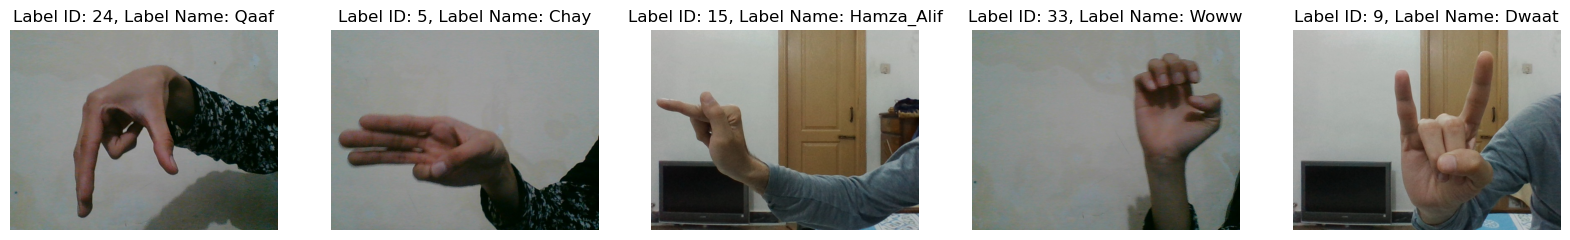

In [106]:
# Function to check label mapping
def check_label_mapping(sample_data, id2label):
    fig, axes = plt.subplots(1, 5, figsize=(20, 5))  # Create a row of 5 subplots
    for i, ax in enumerate(axes):
        image, label_id = sample_data[i]['image'], sample_data[i]['label']
        label_name = id2label[label_id]
        ax.imshow(image)
        ax.set_title(f"Label ID: {label_id}, Label Name: {label_name}")
        ax.axis('off')
    plt.show()

# Check some samples from training data
check_label_mapping(train_data, id2label)

In [107]:
# Initialize ViTImageProcessor
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

C:\Users\Muhammad Hamdan\AppData\Roaming\Python\Python311\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [108]:
# Define image transforms
image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]
print("Size: ", size)

Size:  224


In [109]:
normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose(
        [
            Resize((size, size)),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize((size, size)),
            ToTensor(),
            normalize,
        ]
    )

In [110]:
def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

In [111]:
# Set the transforms
train_data.set_transform(train_transforms)
test_data.set_transform(val_transforms)

In [112]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_dataloader = DataLoader(train_data, collate_fn=collate_fn, batch_size=4)
test_dataloader = DataLoader(test_data, collate_fn=collate_fn, batch_size=4)

In [113]:
# Check batch shape
batch = next(iter(train_dataloader))
for k, v in batch.items():
    if isinstance(v, torch.Tensor):
        print(k, v.shape)

batch = next(iter(test_dataloader))
for k, v in batch.items():
    if isinstance(v, torch.Tensor):
        print(k, v.shape)

pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4])
pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4])


In [114]:
# Load model
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                  id2label=id2label,
                                                  label2id=label2id)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [116]:
# Check for available device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [124]:
metric_name = "accuracy"

args = TrainingArguments(
    "sign-Classification",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return dict(accuracy=accuracy_score(predictions, labels))

trainer = Trainer(
    model,
    args,
    train_dataset=train_data,
    eval_dataset=test_data,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()


  0%|          | 0/12770 [00:00<?, ?it/s]

{'loss': 0.1857, 'grad_norm': 0.2756785452365875, 'learning_rate': 1.9216914643696167e-05, 'epoch': 0.39}
{'loss': 0.0848, 'grad_norm': 0.15698519349098206, 'learning_rate': 1.8433829287392325e-05, 'epoch': 0.78}


  0%|          | 0/320 [00:00<?, ?it/s]

{'eval_loss': 0.045875802636146545, 'eval_accuracy': 0.9998041903270022, 'eval_runtime': 80.4082, 'eval_samples_per_second': 63.513, 'eval_steps_per_second': 3.98, 'epoch': 1.0}
{'loss': 0.0475, 'grad_norm': 0.09750711172819138, 'learning_rate': 1.765074393108849e-05, 'epoch': 1.17}
{'loss': 0.0294, 'grad_norm': 0.05393785238265991, 'learning_rate': 1.686765857478465e-05, 'epoch': 1.57}
{'loss': 0.0197, 'grad_norm': 0.041361164301633835, 'learning_rate': 1.6084573218480817e-05, 'epoch': 1.96}


  0%|          | 0/320 [00:00<?, ?it/s]

{'eval_loss': 0.015834003686904907, 'eval_accuracy': 1.0, 'eval_runtime': 80.7458, 'eval_samples_per_second': 63.248, 'eval_steps_per_second': 3.963, 'epoch': 2.0}
{'loss': 0.0137, 'grad_norm': 0.028989577665925026, 'learning_rate': 1.530148786217698e-05, 'epoch': 2.35}
{'loss': 0.01, 'grad_norm': 0.02252269722521305, 'learning_rate': 1.4518402505873142e-05, 'epoch': 2.74}


  0%|          | 0/320 [00:00<?, ?it/s]

{'eval_loss': 0.007452741265296936, 'eval_accuracy': 0.9998041903270022, 'eval_runtime': 81.7886, 'eval_samples_per_second': 62.441, 'eval_steps_per_second': 3.913, 'epoch': 3.0}
{'loss': 0.0074, 'grad_norm': 0.021254081279039383, 'learning_rate': 1.3735317149569305e-05, 'epoch': 3.13}
{'loss': 0.0056, 'grad_norm': 0.01474516186863184, 'learning_rate': 1.2952231793265467e-05, 'epoch': 3.52}
{'loss': 0.0043, 'grad_norm': 0.011933976784348488, 'learning_rate': 1.216914643696163e-05, 'epoch': 3.92}


  0%|          | 0/320 [00:00<?, ?it/s]

{'eval_loss': 0.00405938969925046, 'eval_accuracy': 0.9998041903270022, 'eval_runtime': 79.7944, 'eval_samples_per_second': 64.002, 'eval_steps_per_second': 4.01, 'epoch': 4.0}
{'loss': 0.0034, 'grad_norm': 0.008965987712144852, 'learning_rate': 1.1386061080657793e-05, 'epoch': 4.31}
{'loss': 0.0027, 'grad_norm': 0.005257199984043837, 'learning_rate': 1.0602975724353955e-05, 'epoch': 4.7}


  0%|          | 0/320 [00:00<?, ?it/s]

{'eval_loss': 0.0025273135397583246, 'eval_accuracy': 0.9998041903270022, 'eval_runtime': 81.1148, 'eval_samples_per_second': 62.96, 'eval_steps_per_second': 3.945, 'epoch': 5.0}
{'loss': 0.0022, 'grad_norm': 0.005726846866309643, 'learning_rate': 9.819890368050119e-06, 'epoch': 5.09}
{'loss': 0.0017, 'grad_norm': 0.004625851754099131, 'learning_rate': 9.036805011746282e-06, 'epoch': 5.48}
{'loss': 0.0014, 'grad_norm': 0.0033766941633075476, 'learning_rate': 8.253719655442444e-06, 'epoch': 5.87}


  0%|          | 0/320 [00:00<?, ?it/s]

{'eval_loss': 0.0018574651330709457, 'eval_accuracy': 0.9998041903270022, 'eval_runtime': 81.7763, 'eval_samples_per_second': 62.451, 'eval_steps_per_second': 3.913, 'epoch': 6.0}
{'loss': 0.0012, 'grad_norm': 0.003913265187293291, 'learning_rate': 7.470634299138607e-06, 'epoch': 6.26}
{'loss': 0.001, 'grad_norm': 0.0026534737553447485, 'learning_rate': 6.687548942834769e-06, 'epoch': 6.66}


  0%|          | 0/320 [00:00<?, ?it/s]

{'eval_loss': 0.001475218334235251, 'eval_accuracy': 0.9998041903270022, 'eval_runtime': 85.1024, 'eval_samples_per_second': 60.01, 'eval_steps_per_second': 3.76, 'epoch': 7.0}
{'loss': 0.0008, 'grad_norm': 0.0023780667688697577, 'learning_rate': 5.904463586530932e-06, 'epoch': 7.05}
{'loss': 0.0007, 'grad_norm': 0.002099179197102785, 'learning_rate': 5.121378230227095e-06, 'epoch': 7.44}
{'loss': 0.0006, 'grad_norm': 0.0014491251204162836, 'learning_rate': 4.338292873923259e-06, 'epoch': 7.83}


  0%|          | 0/320 [00:00<?, ?it/s]

{'eval_loss': 0.0013415457215160131, 'eval_accuracy': 0.9998041903270022, 'eval_runtime': 77.9886, 'eval_samples_per_second': 65.484, 'eval_steps_per_second': 4.103, 'epoch': 8.0}
{'loss': 0.0005, 'grad_norm': 0.0016803055768832564, 'learning_rate': 3.5552075176194207e-06, 'epoch': 8.22}
{'loss': 0.0005, 'grad_norm': 0.0011406389530748129, 'learning_rate': 2.7721221613155836e-06, 'epoch': 8.61}


  0%|          | 0/320 [00:00<?, ?it/s]

{'eval_loss': 0.0011781244538724422, 'eval_accuracy': 0.9998041903270022, 'eval_runtime': 76.7327, 'eval_samples_per_second': 66.556, 'eval_steps_per_second': 4.17, 'epoch': 9.0}
{'loss': 0.0004, 'grad_norm': 0.0011916274670511484, 'learning_rate': 1.9890368050117466e-06, 'epoch': 9.01}
{'loss': 0.0004, 'grad_norm': 0.0011279495665803552, 'learning_rate': 1.2059514487079093e-06, 'epoch': 9.4}
{'loss': 0.0004, 'grad_norm': 0.0011992614017799497, 'learning_rate': 4.228660924040721e-07, 'epoch': 9.79}


  0%|          | 0/320 [00:00<?, ?it/s]

{'eval_loss': 0.0011312911519780755, 'eval_accuracy': 0.9998041903270022, 'eval_runtime': 79.3212, 'eval_samples_per_second': 64.384, 'eval_steps_per_second': 4.034, 'epoch': 10.0}
{'train_runtime': 7238.3058, 'train_samples_per_second': 28.218, 'train_steps_per_second': 1.764, 'train_loss': 0.01668600782448646, 'epoch': 10.0}


TrainOutput(global_step=12770, training_loss=0.01668600782448646, metrics={'train_runtime': 7238.3058, 'train_samples_per_second': 28.218, 'train_steps_per_second': 1.764, 'total_flos': 1.5832703944382976e+19, 'train_loss': 0.01668600782448646, 'epoch': 10.0})

In [125]:
# Evaluate the model
outputs = trainer.predict(test_data)

  0%|          | 0/320 [00:00<?, ?it/s]

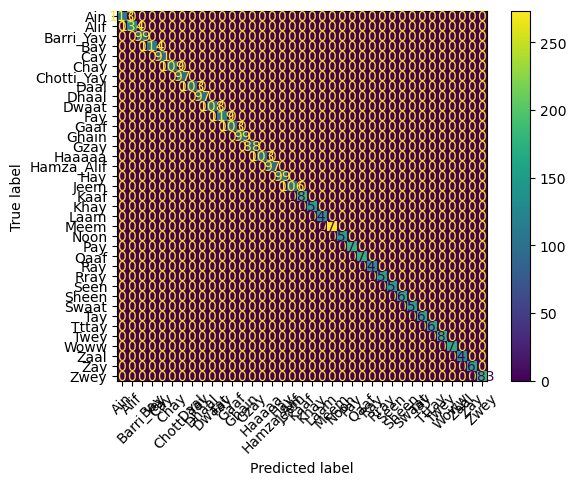

In [126]:
# Confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)
plt.show()

In [127]:
model_save_path = "./10epochs_model"

In [128]:
# Save the model and processor
trainer.save_model(model_save_path)
processor.save_pretrained(model_save_path)

['./10epochs_model\\preprocessor_config.json']

In [ ]:
# Evaluate the model
outputs = trainer.predict(test_data)

In [ ]:
# Load the saved model and processor
model = ViTForImageClassification.from_pretrained(model_save_path)
processor = ViTImageProcessor.from_pretrained(model_save_path)

In [ ]:
# Function to preprocess images
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt")
    return inputs

# Function to make predictions
def predict(image_path):
    inputs = preprocess_image(image_path)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    predicted_class_idx = logits.argmax(-1).item()
    return model.config.id2label[predicted_class_idx]

In [ ]:
# Example usage for prediction
image_path = "../Test Images/IMG_20240516_174531_372.jpg"  # Update the path if necessary
predicted_label = predict(image_path)
print(f"The predicted label for the image is: {predicted_label}")

In [ ]:
# Import necessary libraries
import cv2
import torch
from PIL import Image
from transformers import ViTForImageClassification, ViTImageProcessor

# Function to preprocess images
def preprocess_image(image):
    image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    inputs = processor(images=image, return_tensors="pt")
    return inputs

# Function to make predictions
def predict(image):
    inputs = preprocess_image(image)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    predicted_class_idx = logits.argmax(-1).item()
    return model.config.id2label[predicted_class_idx]

# Start video capture from webcam
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Make prediction
    label = predict(frame)

    # Display the resulting frame
    cv2.putText(frame, f"Predicted Alphabet: {label}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
    cv2.imshow('Alphabet Recognition', frame)

    # Break the loop on 'q' key press
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything is done, release the capture
cap.release()
cv2.destroyAllWindows()